ValueError: x and y must have same first dimension, but have shapes (40,) and (195,)

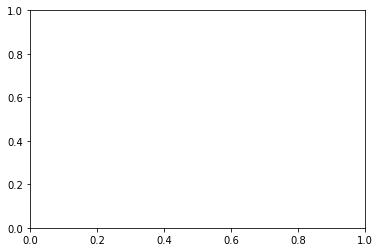

In [7]:
# %%
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from numpy import linalg as LA
import numpy as np
import pandas as pd
import warnings
from fcnn import *
warnings.simplefilter(action='ignore', category=FutureWarning)

# %%
data = pd.DataFrame(columns=['x', 'y'])

with open(r"Group24\Group24\Classification\NLS_Group24.txt") as f:
# with open(r"Group19\Group19\Classification\NLS_Group19.txt") as f:
# with open(r"Group18\Group18\Classification\NLS_Group18.txt") as f:
    cnt = 0
    while True:
        line = f.readline()
        if not line:
            break
        if(line[0] == 'F'):
            continue
        cords = line.split(' ')
        cords[0] = float(cords[0])
        cords[1] = float(cords[1])
        data = data.append({'x': cords[0], 'y': cords[1]}, ignore_index=True)

c1_data = data.iloc[:300, :]
c2_data = data.iloc[300:800, :]
c3_data = data.iloc[800:1800, :]
data_c1_train = c1_data.iloc[0:210, :]
data_c2_train = c2_data.iloc[0:350, :]
data_c3_train = c3_data.iloc[0:700, :]
data_c1_test = c1_data.iloc[210:, :]
data_c2_test = c2_data.iloc[350:, :]
data_c3_test = c3_data.iloc[700:, :]

class Layer:

    num_nodes = int
    an = []
    gn = []
    delta = []

    def __init__(self, nodes):
        self.num_nodes = nodes

    def activation_function(self, a):
        f = 1 + np.exp(-a)
        return 1/f

    def apply_act_func(self):
        self.gn = self.activation_function(np.array(self.an))
        self.gn[0] = 1


class Model:
    num_layers = 0
    layers = []
    weights = []
    total_error = []
    eta = int

    def __init__(self, eta=0.01):
        self.eta = eta
        self.num_layers = 0
        self.layers = []
        self.weights = []
        self.total_error = []

    def clean_layers(self):
        for l in self.layers:
            l.an = []
            l.gn = []
            l.delta = []

    def add_layer(self, num_nodes):
        new_layer = Layer(num_nodes)
        self.layers.append(new_layer)
        self.num_layers += 1
        if(self.num_layers >= 2):
            n1 = self.layers[self.num_layers-2].num_nodes
            n2 = new_layer.num_nodes
            self.weights.append(np.random.randn(n2, n1+1))

    def update_wts(self,target):
        for iter in range(len(self.weights)-1,-1,-1):

            wt_mat = self.weights[iter]
            delta_mat = np.ones([len(wt_mat), len(wt_mat[0])], float)

            if(iter == len(self.weights)-1):
                for k in range(1,self.layers[iter+1].num_nodes+1):
                    fa = self.layers[iter+1].gn[k]
                    self.layers[iter+1].delta.append((-fa + target[k-1]) * fa * (1 - fa))
            else :
                for l in range(1,self.layers[iter+1].num_nodes+1):
                    gnl = self.layers[iter+1].gn[l]
                    delta_nl = gnl * (1 - gnl)
                    sum_del = 0
                    for k in range(0,self.layers[iter+2].num_nodes):
                        wlk_mat = self.weights[iter+1]
                        sum_del += (self.layers[iter+2].delta[k] * wlk_mat[k][l])
                    delta_nl *= sum_del
                    self.layers[iter+1].delta.append(delta_nl)
                
            for k in range(len(wt_mat)):
                for j in range(len(wt_mat[0])):
                    hnj = self.layers[iter].gn[j]
                    delta = self.layers[iter+1].delta[k]
                    delta_mat[k][j] = self.eta * delta * hnj
            self.weights[iter] += delta_mat 
     
    def fit(self, x, target):
        for i in range(len(x)):
            xn = np.insert(x[i], 0, 1, axis=None)
            yn = target[i]
            self.layers[0].gn = xn

            for wt_i in range(len(self.weights)):
                an = np.dot(self.weights[wt_i], self.layers[wt_i].gn)
                an = np.insert(an, 0, 1, axis=None)
                self.layers[wt_i+1].an = an
                self.layers[wt_i+1].apply_act_func()

            inst_error = np.array(
                self.layers[self.num_layers-1].gn[1:]) - target[i]
            self.total_error.append(np.sum(np.square(inst_error))/2)
            # self.update_weights(target[i])
            self.update_wts(target[i])
            self.clean_layers()

    def classify_batch(self, x):
        predictions = []
        for i in range(len(x)):
            xn = np.insert(x[i], 0, 1, axis=None)
            self.layers[0].gn = xn

            for wt_i in range(len(self.weights)):
                an = np.dot(self.weights[wt_i], self.layers[wt_i].gn)
                an = np.insert(an, 0, 1, axis=None)
                self.layers[wt_i+1].an = an
                self.layers[wt_i+1].apply_act_func()
            predictions.append(
                np.argmax(self.layers[self.num_layers-1].gn[1:])+1)
            self.clean_layers()
        return predictions

    def classify_point(self, x):
        xn = np.insert(x, 0, 1, axis=None)
        self.layers[0].gn = xn

        for wt_i in range(len(self.weights)):
            an = np.dot(self.weights[wt_i], self.layers[wt_i].gn)
            an = np.insert(an, 0, 1, axis=None)
            self.layers[wt_i+1].an = an
            self.layers[wt_i+1].apply_act_func()
        op = np.argmax(self.layers[self.num_layers-1].gn[1:])+1
        self.clean_layers()
        return op

    def avg_training_error(self):
        return np.mean(self.total_error)


# def repeat(lay1,lay2):
# %%
# Making the model
epochs = 40
FCNN = Model()
FCNN.add_layer(2)
FCNN.add_layer(30)
FCNN.add_layer(30)
# FCNN.add_layer(8)
FCNN.add_layer(3)

# %%
# Fitting the model to the data
errors = []
# for epoch in range(1, epochs+1):
    # FCNN.eta = 1/epoch
while True:
    FCNN.fit(data_c1_train.to_numpy(), np.tile(np.array(
        [1, 0, 0]), data_c1_train.shape[0]).reshape(data_c1_train.shape[0], 3))
    FCNN.fit(data_c2_train.to_numpy(), np.tile(np.array(
        [0, 1, 0]), data_c2_train.shape[0]).reshape(data_c2_train.shape[0], 3))
    FCNN.fit(data_c3_train.to_numpy(), np.tile(np.array(
        [0, 0, 1]), data_c3_train.shape[0]).reshape(data_c3_train.shape[0], 3))
    # print("Average training error = ", FCNN.avg_training_error())
    errors.append(FCNN.avg_training_error())
    if(len(errors)>1 and abs(errors[len(errors)-1]-errors[len(errors)-2])<0.0001): break

# %%
# Plotting epoch vs training error
plt.plot([i for i in range(1, len(errors)+1)], errors)
plt.title("Training error vs epoch")
plt.xlabel("Epochs")
plt.ylabel("Average Error")
plt.grid()
plt.show()
# plt.savefig("./results/epoch_h1_{}_h2_{}.jpg".format(lay1,lay2))

# %%
# Classifying the testing data
prediction = FCNN.classify_batch(data_c1_test.to_numpy())
prediction = prediction + FCNN.classify_batch(data_c2_test.to_numpy())
prediction = prediction + FCNN.classify_batch(data_c3_test.to_numpy())

# %%
# Plotting the training data
plt.scatter(data_c1_train.x, data_c1_train.y, s=30, edgecolors='black')
plt.scatter(data_c2_train.x, data_c2_train.y, s=30, edgecolors='black')
plt.scatter(data_c3_train.x, data_c3_train.y, s=30, edgecolors='black')
plt.title('Dataset 2')
plt.xlabel('feature 1')
plt.ylabel('feature 2')
plt.grid()
plt.legend(['Class 1', 'Class 2', 'Class 3'])
# plt.axis('off')
# plt.show()

# %%
# Creating one dataframe for testing data
classes = []
for j in range(len(data_c1_test.x)):
    classes.append(1)
for j in range(len(data_c2_test.x)):
    classes.append(2)
for j in range(len(data_c3_test.x)):
    classes.append(3)
test_data = pd.concat([data_c1_test, data_c2_test, data_c3_test])
test_data['class'] = classes

# %%
# Computing testing data classification accuacy
print("Accuracy = ", accuracy_score(test_data["class"], prediction))

print("Confusion Matrix = \n", confusion_matrix(
    test_data['class'], prediction))

# %%
# creating the mesh to achieve the decision boundaries
xmin = min(data_c1_train.min()[0], data_c2_train.min()[
        0], data_c3_train.min()[0])
ymin = min(data_c1_train.min()[1], data_c2_train.min()[
        1], data_c3_train.min()[1])

xmax = max(data_c1_train.max()[0], data_c2_train.max()[
        0], data_c3_train.max()[0])
ymax = max(data_c1_train.max()[1], data_c2_train.max()[
        1], data_c3_train.max()[1])

xx = np.linspace(xmin-2, xmax+2, 100)
yy = np.linspace(ymin-2, ymax+2, 100)

# %%
# Combining training data
training_data = pd.concat([data_c1_train, data_c2_train, data_c3_train])
classes = []
for j in range(len(data_c1_train.x)):
    classes.append(1)
for j in range(len(data_c2_train.x)):
    classes.append(2)
for j in range(len(data_c3_train.x)):
    classes.append(3)
training_data['class'] = classes

# %%
# Creating decision boundary between all classes
predicted_mesh = pd.DataFrame(columns=['x', 'y', 'pred'])
for i in xx:
    for j in yy:
        cord = np.array([i, j])
        predicted_mesh = predicted_mesh.append(
            {'x': cord[0], 'y': cord[1], 'pred': FCNN.classify_point(cord)}, ignore_index=True)

# %%
# Superimposing the decision boundary onto the training data
fig, ax = plt.subplots()

scatter1 = ax.scatter(
    predicted_mesh['x'], predicted_mesh['y'], c=predicted_mesh['pred'], alpha=0.2, s=10)
scatter2 = ax.scatter(
    training_data['x'], training_data['y'], c=training_data['class'], alpha=1, s=10, edgecolors='black')
# produce a legend with the unique colors from the scatter
legend1 = ax.legend(*scatter1.legend_elements(),
                    loc="lower left", title="Classes")
plt.grid()
ax.add_artist(legend1)

plt.xlabel("feature 1")
plt.ylabel("feature 2")
plt.title("Decision Regions and Training Data")#, h1={}, h2={}".format(lay1,lay2))
# plt.savefig('./results/h1_{}_h2_{}.jpg'.format(lay1,lay2))
plt.show()